Portfolio selection problem with the risk-adjusted objective function

In [81]:
using Distributions, JuMP, Plots, HiGHS, PlotlyJS, LinearAlgebra
# creating scenarios for the problem
N_scenarios = 150
n_assets = 8
p = (1/N_scenarios)*ones(N_scenarios)
normal = Normal(1, 0.3)
r = rand(normal, N_scenarios, n_assets)

150×8 Matrix{Float64}:
 0.89047   0.722108  1.16557    1.17696    …  0.650733  0.934741  0.784987
 1.42063   1.08172   0.748923   1.42313       1.45058   1.14897   0.621303
 1.13071   1.04681   0.75794    1.15687       0.807096  1.13107   1.12424
 0.939388  1.1255    1.26137    1.00735       1.55337   1.22157   0.798834
 1.17388   0.577401  1.1902     0.880472      0.765172  1.54451   0.936675
 0.614446  1.21002   0.735666   1.08654    …  1.03573   1.07678   0.644146
 1.34786   1.17759   1.06415    0.0893919     0.981965  0.677858  0.941692
 1.12353   0.959925  1.25875    0.736789      1.17784   1.26901   1.45894
 0.483858  0.60451   0.569091   1.0146        0.950949  0.916559  0.902923
 1.03793   1.06369   1.14723    1.48741       0.629703  0.954095  1.10472
 ⋮                                         ⋱  ⋮                   
 1.03782   1.31994   0.773759   1.31426       1.10967   1.12491   1.15706
 1.02794   0.869766  0.962781   0.468294      0.699867  0.873542  0.979958
 0.68141   1.1

In [2]:
plotlyjs()


Plots.PlotlyJSBackend()

In [147]:
λ = 0.1
α = 0.95


0.95

In [148]:
function cvar(x)
    m = Model(HiGHS.Optimizer)
    set_silent(m)
    @variable(m, l)
    @variable(m, θ[1:N_scenarios])
    @constraint(m, con1[s=1:N_scenarios], θ[s] ≥ 0)
    @constraint(m, con2[s=1:N_scenarios], θ[s] ≥ (-r[s, :] ⋅ x) - l)
    @objective(m, Min, l + sum(p[s]*θ[s] for s=1:N_scenarios)/(1-α))
    optimize!(m)
    return objective_value(m)
end

cvar (generic function with 1 method)

In [149]:
function RiskAdjustedOptimization(r, N_samples, n_assets, λ)
    m = Model(HiGHS.Optimizer)
    set_silent(m)
    @variables(m, begin
        x[1:n_assets] ≥ 0
        θ[1:N_samples] ≥ 0
        l
    end)
    @constraint(m, con1, sum(x) == 1)
    @constraint(m, con2[s=1:N_samples], θ[s] ≥ -r[s, :] ⋅ x - l)
    @objective(m, Min, λ*sum(p[s] * (-r[s, :] ⋅ x) for s = 1:N_samples) + (1-λ)*(l + sum(p[s] * θ[s]/(1-α) for s = 1:N_samples)))
    optimize!(m)
    return value.(x), objective_value(m)
end

RiskAdjustedOptimization (generic function with 1 method)

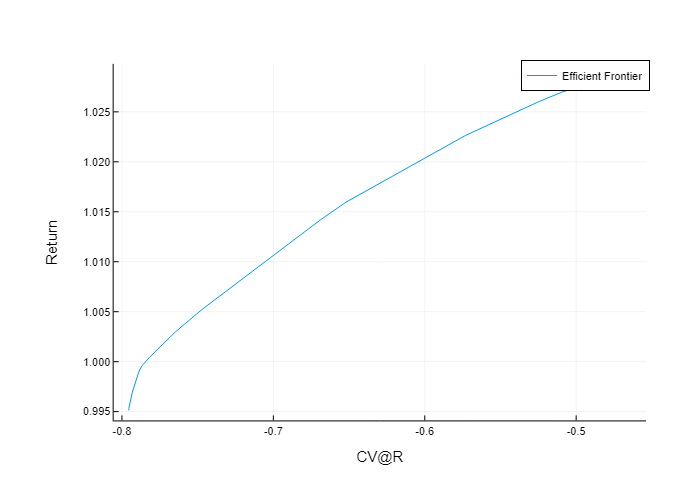

In [156]:
# Plotting Efficient Frontier by varying λ
lambdas = collect(0:0.01:1)
risks = zeros(length(lambdas))
returns = zeros(length(lambdas))
for i = 1:length(lambdas)
    x, obj = RiskAdjustedOptimization(r, N_scenarios, n_assets, lambdas[i])
    risks[i] = cvar(x)
    returns[i] = sum(r[s,:] ⋅ x for s = 1:N_scenarios)/N_scenarios
end

Plots.plot(risks, returns, label = "Efficient Frontier", xlabel = "CV@R", ylabel = "Return", legend = :best)

Portfolio selection with CV@R-based risk constraint

In [152]:
function PortfolioRiskContraint(r, N_samples, n_assets, γ)
    m = Model(HiGHS.Optimizer)
    set_silent(m)
    @variables(m, begin
        x[1:n_assets] ≥ 0
        θ[1:N_samples] ≥ 0
        l
    end)
    @constraint(m, con1, sum(x) == 1)
    @constraint(m, con2[s=1:N_samples], θ[s] ≥ -r[s, :] ⋅ x - l)
    @constraint(m, con3, l + sum(p[s]*θ[s]/(1-α) for s = 1:N_samples) ≤ γ)
    @objective(m, Min, sum(p[s] * (-r[s, :] ⋅ x) for s = 1:N_samples))
    optimize!(m)
    return value.(x), objective_value(m), value(l)
end

PortfolioRiskContraint (generic function with 1 method)

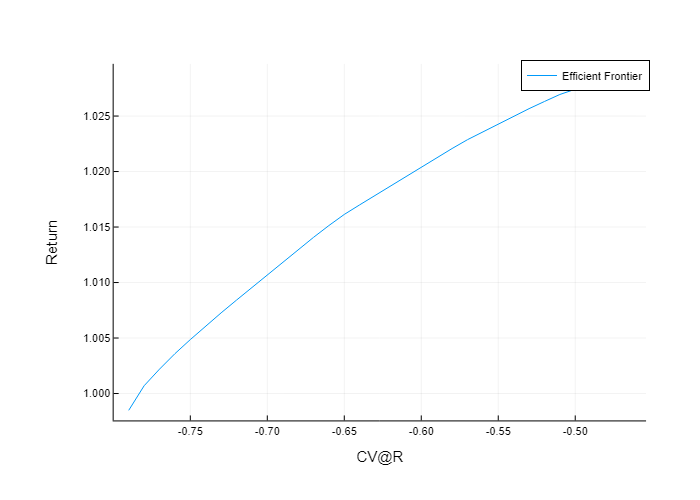

In [153]:
# Plotting Efficient Frontier by varying γ

gammas = collect(-0.79:0.01:0)
risks = zeros(length(gammas))
returns = zeros(length(gammas))
for i = 1:length(gammas)
    x, obj = PortfolioRiskContraint(r, N_scenarios, n_assets, gammas[i])
    risks[i] = cvar(x)
    returns[i] = sum(r[s,:] ⋅ x for s = 1:N_scenarios)/N_scenarios
end

Plots.plot(risks, returns, label = "Efficient Frontier", xlabel = "CV@R", ylabel = "Return", legend = :best)